<a href="https://colab.research.google.com/github/SimNaeun/Google_Bootcamp/blob/main/KerasNLP_starter_notebook_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
#-q 설치 중에 출력되는 로그와 메시지를 최소화

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.9/944.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.0 MB/s eta 0:00:00


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow' #Keras 딥 러닝 라이브러리가 백엔드 엔진으로 TensorFlow를 사용하도록 명시

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.13.0
KerasNLP version: 0.6.1


In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
#{:.2f} 소수점 둘째 자리까지 출력
#1024의 제곱=1 MB, MB 단위로 표시
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))
print("Train Length Stat")
print(df_train["length"].describe())
print()
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE #// 정수 나눗셈(나머지를 버리고 정수 부분만 취함)
EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE # 데이터 로딩 및 전처리와 같은 데이터 파이프라인 작업을 병렬로 처리하면서 데이터 로딩 시간을 최소화

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
#random_state=42 동일한 시드를 사용하여 재현성 확보
X_test = df_test["text"]

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
#DistilBERT BERT보다 모델 크기를 줄이고 계산 비용을 감소시킴으로써 BERT의 효과를 일부 유지하면서도 더 경량화된 모델
#base 모델의 크기와 복잡성(large 더 크고 복잡한 모델)
#en 영어
#uncased 대소문자를 구분하지 않음

In [ ]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets")
#전처리: 텍스트 데이터를 모델에 입력가능한 형식으로 변환
#모델에 입력될 시퀀스의 길이를 160으로 제한
#preset 사전 정의된 데이터 전처리 설정


231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


In [ ]:
# Pretrained classifier.
#keras_nlp.models.DistilBertClassifier DistilBERT를 "텍스트 분류 작업"에 사용할 수 있도록 특수하게 조정된 모델
#num_classes=2 이진분류 모델(0, 1)
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)
classifier.summary()

265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile 모델 설정
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',??
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"])
#from_logits=True 모델의 출력값이 확률로 변환되지 않은 logits 값을 사용
#SparseCategoricalCrossentropy??
#metrics 모델의 성능을 평가할 지표= accuracy
#accuracy = (TP + TN)/(TP + FP + TN + FN)
#학습률: 1e-5 적은 변화로 과적합 및 경사하강법의 발산 방지&사전 학습된 모델을 사용할 경우 가중치를 데이터에 맞게 미세조정

In [ ]:
#classifier.fit 모델 훈련
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )
#Confusion Matrix을 시각화하고 F1 Score를 계산하여 표시
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1), #열을 기준으로 가장 높은 확률을 가진 클래스의 인덱스
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel() #ravel 배열(또는 행렬)을 1차원 배열로 펼치는 함수
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 649ms/step - accuracy: 0.7040 - loss: 0.5698 - val_accuracy: 0.8418 - val_loss: 0.4006
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 116s 607ms/step - accuracy: 0.8363 - loss: 0.3819 - val_accuracy: 0.8444 - val_loss: 0.3813


191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step


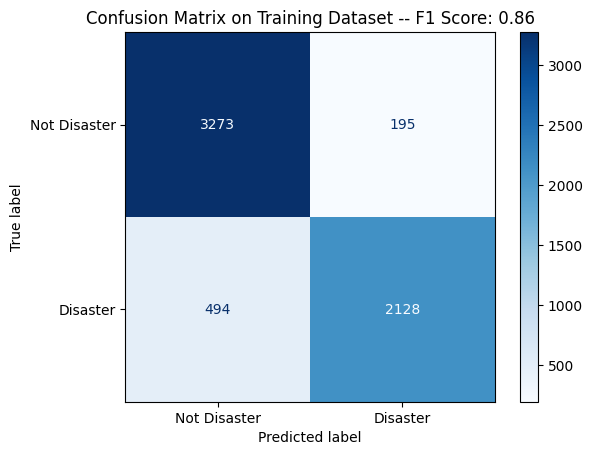

In [ ]:
y_pred_train = classifier.predict(X_train)
#classifier.prredict 입력 데이터에 대한 예측을 수행, 데이터 레이블 or 확률분포 반환

displayConfusionMatrix(y_train, y_pred_train, "Training")
# f1 score: 0.86
#0.0에서 0.2: 매우 낮은 성능
#0.2에서 0.4: 낮은 성능
#0.4에서 0.6: 보통의 성능
#0.6에서 0.8: 좋은 성능
#0.8에서 1.0: 매우 뛰어난 성능

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step


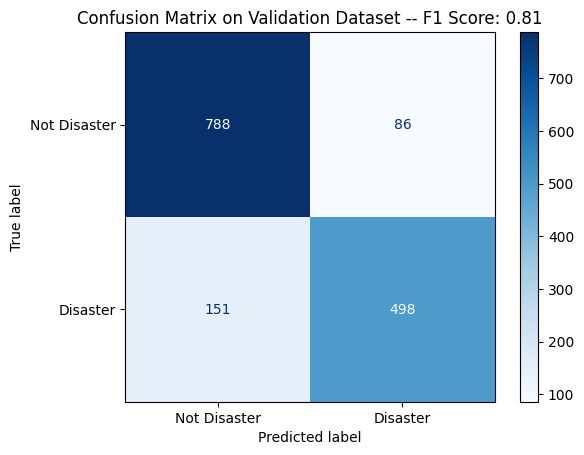

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")
#f1 score:0.81

In [ ]:
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step


In [ ]:
sample_submission.describe()
sample_submission.to_csv("submission.csv", index=False)